In [11]:
import numpy as np
from numpy import random
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
class autoencoder():
    def __init__(self,d,n1):
        self.W1 = random.uniform(-6**0.5/(n1+d)**0.5,6**0.5/(n1+d)**0.5,size = (n1,d))
        self.dnh1 = np.zeros((n1,d))
        self.dhp1 = np.zeros((n1,d))
        self.b1 = np.zeros(n1)
        self.dnh2 = np.zeros(n1)
        self.dhp2 = np.zeros(n1)
        self.W2 = random.uniform(-6**0.5/(n1+d)**0.5,6**0.5/(n1+d)**0.5,size = (d,n1))
        self.dnh3 = np.zeros((d,n1))
        self.dhp3 = np.zeros((d,n1))
        self.b2 = np.zeros(d)
        self.dnh4 = np.zeros(d)
        self.dhp4 = np.zeros(d)
        self.d = d
        self.n1 = n1
    def h1(self,a):
        return np.maximum(a,0)
    def h2(self,a):
        return 1./(1+np.exp(-a))
    def dh1(self,a):
        return np.sign(self.h1(a))
    def dh2(self,a):
        return (np.multiply(self.h2(a),1-self.h2(a)))
    def loss(self,Xbatch):
        dm = np.size(Xbatch)
        #print(np.size(Xbatch,0),np.size(Xbatch,1))
        #print(np.size(self.W1,0),np.size(self.W1,1))
        #print(np.size(self.W2,0),np.size(self.W2,1))
        #print(np.size(self.b1,0))
        net_a = self.W1@Xbatch+np.reshape(self.b1,(self.n1,1))
        net_b = self.W2@self.h1(net_a)+np.reshape(self.b2,(self.d,1))
        Y = self.h2(net_b)
        loss_batch = np.sum(np.multiply(Xbatch,np.log(Y)))+ \
                            np.sum(np.multiply(1-Xbatch,np.log(1-Y)))
        loss_batch = (-1/dm)*loss_batch
        print(loss_batch)
        return loss_batch
    def forward(self,Xbatch):
        self.Xbatch = Xbatch
        self.a1 = self.W1@Xbatch + np.reshape(self.b1,(self.n1,1))
        self.o1 = self.h1(self.a1)
        self.a2 = self.W2@self.o1+ np.reshape(self.b2,(self.d,1))
        self.o2= self.h2(self.a2)
    def dloss(self,Ybatch):
        Xbatch = self.Xbatch
        dm = np.size(Xbatch)
        return (-1/dm)*(np.divide(Xbatch,Ybatch)+np.divide(Xbatch-1,1-Ybatch))
    def backward(self):
        delta2 = np.multiply(self.dloss(self.o2),self.dh2(self.a2))
        self.dW2 = delta2@(np.transpose(self.o1))
        #print(np.size(self.dW2,1),np.size(self.dW2,0))
        self.db2 = np.sum(delta2,axis = 1)
        delta1= np.multiply(np.transpose(self.W2)@delta2,self.dh1(self.a1))
        self.dW1 = delta1@(np.transpose(self.Xbatch))
        #print(np.size(self.dW1,1),np.size(self.dW1,0))
        self.db1 = np.sum(delta1,axis = 1)
        #print(np.size(self.db1,0))
    def adam_step(self,alpha,rho1,rho2,delta,iter):
        self.dnh1 =  rho1*self.dnh1 + (1-rho1)*self.dW1
        self.dhp1 = rho2*self.dhp1 + (1-rho2)*np.multiply(self.dW1,self.dW1)
        nudh = (1-rho1**iter)**(-1)*self.dnh1
        nuh = (1-rho2**iter)**(-1)*self.dhp1
        self.W1 = self.W1 -alpha*(nudh/(nuh**0.5+delta))
        self.dnh2 =  rho1*self.dnh2 + (1-rho1)*self.db1
        self.dhp2 = rho2*self.dhp2 + (1-rho2)*np.multiply(self.db1,self.db1)
        nudh = (1-rho1**iter)**(-1)*self.dnh2
        nuh = (1-rho2**iter)**(-1)*self.dhp2
        self.b1 = self.b1 -alpha*(nudh/(nuh**0.5+delta))
        self.dnh3 = rho1*self.dnh3 + (1-rho1)*self.dW2
        self.dhp3 = rho2*self.dhp3 + (1-rho2)*np.multiply(self.dW2,self.dW2)
        nudh = (1-rho1**iter)**(-1)*self.dnh3
        nuh = (1-rho2**iter)**(-1)*self.dhp3
        self.W2 = self.W2 -alpha*(nudh/(nuh**0.5+delta))
        self.ndh4 = rho1*self.dnh4 + (1-rho1)*self.db2
        self.dhp4 = rho2*self.dhp4 + (1-rho2)*np.multiply(self.db2,self.db2)
        nudh = (1-rho1**iter)**(-1)*self.dnh4
        nuh = (1-rho2**iter)**(-1)*self.dhp4
        self.b2= self.b2 -alpha*(nudh/(nuh**0.5+delta))
        
    def sgd(self,alpha):
        self.W1 = self.W1 - alpha*self.dW1
        self.b1 = self.b1 - alpha*self.db1
        self.W2 = self.W2 - alpha*self.dW2
        self.b2 = self.b2 - alpha*self.db2


In [12]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [13]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [14]:
Xtrain = np.transpose(tf.reshape(train_images,[60000,784]))

In [15]:
ae = autoencoder(784,100)
numepochs = 50
numsplits = 2000
iter = 1
alpha = 0.001
rho1 = 0.9
rho2 = 0.999
delta = 1e-8
ntrain = np.arange(60000)
for e in range(numepochs):
    print('Training loss [%d/%d]: %.2f' % (e+1, numepochs, ae.loss(Xtrain)))
    minibatches = np.split(np.random.permutation(ntrain), numsplits)
    for indices in minibatches:
        Xbatch = Xtrain[:, indices]
        ae.forward(Xbatch)
        ae.backward()
        ae.adam_step(alpha,rho1,rho2,delta,iter)
        #ae.sgd(alpha)
        iter = iter + 1
    

0.6990894018833829
Training loss [1/50]: 0.70
0.27779361362255334
Training loss [2/50]: 0.28
0.27046840269525907
Training loss [3/50]: 0.27
0.26953974047903645
Training loss [4/50]: 0.27
0.2661672421593002
Training loss [5/50]: 0.27
0.26572342978988445
Training loss [6/50]: 0.27
0.2651029604863808
Training loss [7/50]: 0.27
0.26468794831013703
Training loss [8/50]: 0.26
0.2644148014128159
Training loss [9/50]: 0.26
0.2645072613785828
Training loss [10/50]: 0.26
0.26438534015849974
Training loss [11/50]: 0.26
0.26453384167962707
Training loss [12/50]: 0.26
0.26416099892220174
Training loss [13/50]: 0.26
0.2638461814343159
Training loss [14/50]: 0.26
0.26374391663242785
Training loss [15/50]: 0.26
0.26384920716913435
Training loss [16/50]: 0.26
0.263725311886191
Training loss [17/50]: 0.26
0.2637016952691293
Training loss [18/50]: 0.26
0.2637840597881786
Training loss [19/50]: 0.26
0.26393246054671365
Training loss [20/50]: 0.26
0.2636291510158675
Training loss [21/50]: 0.26
0.2635487124

0.26600252756019865
0.26600252756019865


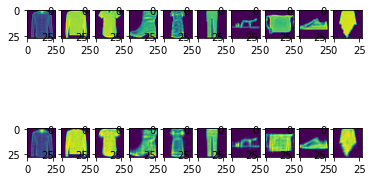

In [20]:
Xtest = np.transpose(tf.reshape(test_images,[10000,784]))
Xtest = Xtest
print(ae.loss(Xtest))
y_train = test_labels
# plot the figure with the original data
f, axarr = plt.subplots(2,10)
count = []
i = 0
rand = np.arange(10000)
np.random.shuffle(rand)
while i < np.size(y_train)  and np.size(count) <=9:
    
    if y_train[rand[i]] not in count:     
        count.append(y_train[rand[i]])
        j = np.size(count
                   
                   )
        axarr[(0,(j-1))].imshow(np.reshape(Xtest[:,rand[i]]*255,(28,28)))
        ae.forward(np.reshape(Xtest[:,rand[i]],(784,1)))
        Image = ae.o2
        axarr[(1,(j-1))].imshow(np.reshape(Image*255,(28,28)))
        
    i = i + 1